In [1]:
import numpy as np
import pandas as pd
from scipy.stats import halfnorm
from scipy.stats import expon
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

from sfma.api import SFMAModel
from helpers import Simulator

Simulate some test data and get the "true" frontier.

In [2]:
np.random.seed(10)

In [3]:
s = Simulator(nu=0.4, # variance of inefficiency
              gamma=0.01, # random effect variance
              sigma_min=0.1, # measurement error lower (will sample uniformly)
              sigma_max=0.2, # measurement error upper (will sample uniformly)
              ineff_dist='half-normal', # inefficiency distribution
              x=lambda size: stats.uniform.rvs(size=size, loc=0.0, scale=10), # sample a single covariate
              func=lambda x: np.log(5 * x + 1.5)) # the functional form of the frontier
us, vs, epsilon, sigma, xs, front, observed = s.simulate(n=1000)

x_front = np.linspace(xs.min(), xs.max())
y_front = s.func(np.linspace(xs.min(), xs.max()))

In [4]:
sim = pd.DataFrame({'output': observed, 'input': xs, 'se': sigma})
sim.sort_values('input', inplace=True)

Create a model object, fit it, and add predictions to the data frame.

In [5]:
model = SFMAModel(
    
    # INPUT DATA + COLUMNS
    df=sim, # data frame with below columns in it
    col_output='output', # output column
    col_se='se', # standard error for outputs
    col_input='input', # input column -- only one at this time
    
    # SHAPE CONSTRAINTS
    concave=True, # force concavity of frontier
    convex=False, # force convexity of frontier
    increasing=True, # force increasing trend
    decreasing=False, # force decreasing trend
    r_linear=False, # whether to require linear tails to the right for the spline
    l_linear=False, # whether to require linear tails to the left for the spline
    constr_grid_num=20, # sensible default, if constraints are not being enforced properly, make this larger
    
    # SPLINES
    knots_num=4, # how many knots for spline
    knots_type="domain", # should knots be spaced evenly or based on frequency of data ("frequency")
    knots_degree=3, # degree of the spline, e.g., 3=cubic
    
    # ESTIMATION OF RANDOM EFFECTS
    include_gamma=True, # whether to include random effects -- one per observation
    
    # ESTIMATE AN INTERCEPT
    include_intercept=True, # this should pretty much always be true
    
    # TRIMMING
    pct_trimming=0.01 # what proportion of the data should be trimmed as outliers
)

model.fit()

/opt/miniconda3/envs/sfma/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Trimming iteration:  4 / 100 -- error:  0.145343
Model converged successfully! :)


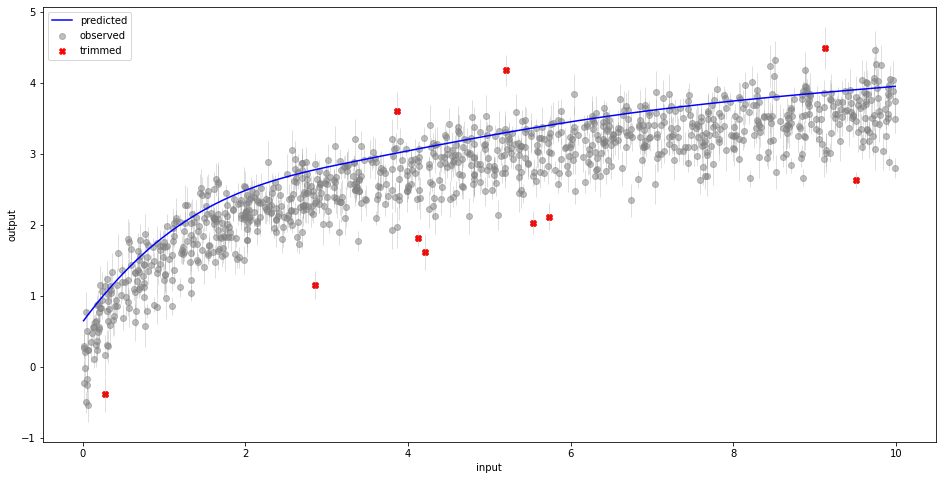

In [7]:
model.plot_frontier(sim, true_frontier=np.array([x_front, y_front]).T)